# Explore here

In [1]:
#Importamos Librerias Necesarias

import pandas as pd
import numpy as np
from numpy.random import seed, choice
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.metrics import specificity_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import *

EL DATAFRAME DE ESTE PROYECTO 'DIABETES.CSV' YA ESTE PREPROCESADO.
SE INCLUYE SOLO DE REFERENCIA

# EDA

In [2]:
# Cargamos el dataset
df = pd.read_csv('../data/raw/diabetes.csv')

# Visualizaciones

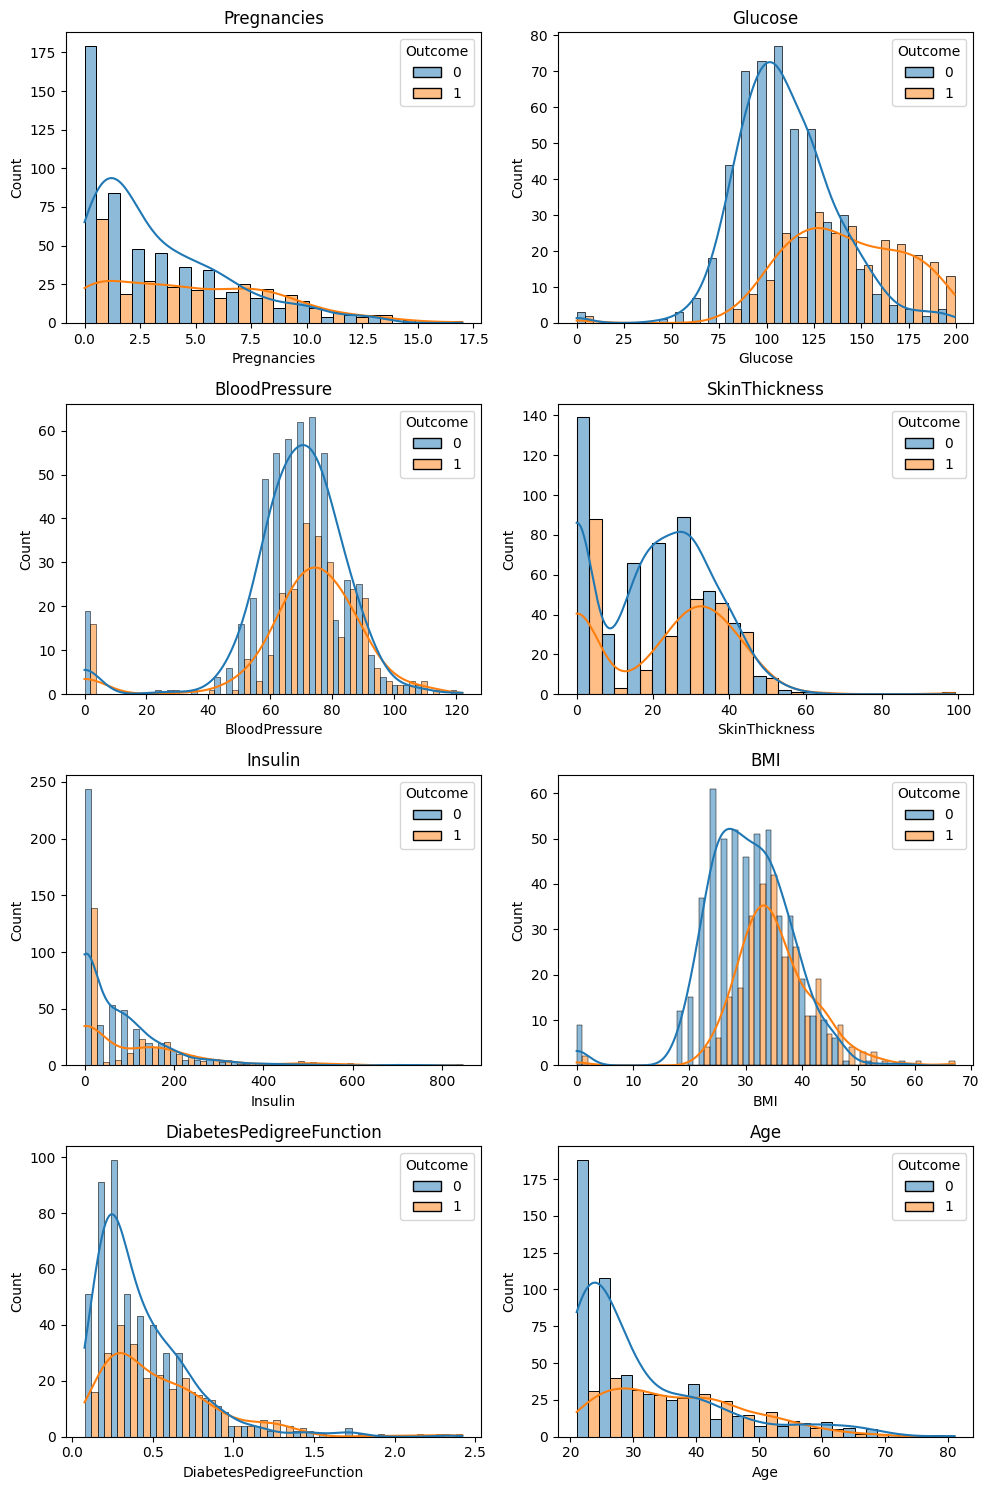

In [3]:
# Seleccinamos las columnas a graficar
columnas = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Creamos hisplot para cada una
fig, axes = plt.subplots(4, 2, figsize=(10, 15))
axes = axes.flatten()  # Convertimos los ejes en una lista plana para iterar

# Iteramos por cada columna del dataframe
for i, columna in enumerate(columnas):
    sns.histplot(ax=axes[i], x=columna, data=df, hue='Outcome', kde=True, multiple='dodge')  
    axes[i].set_title(columna)

# Para mostrar el gráfico
plt.tight_layout()
plt.show()

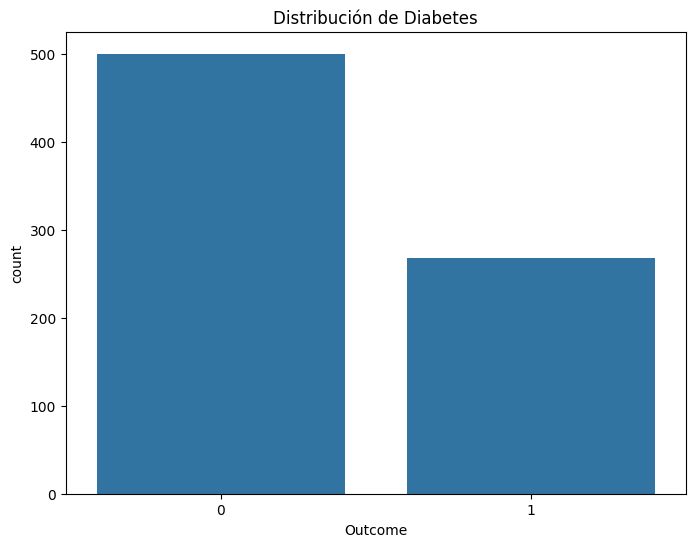

In [4]:
# Distribución de la variable objetivo
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=df)
plt.title('Distribución de Diabetes')
plt.show()

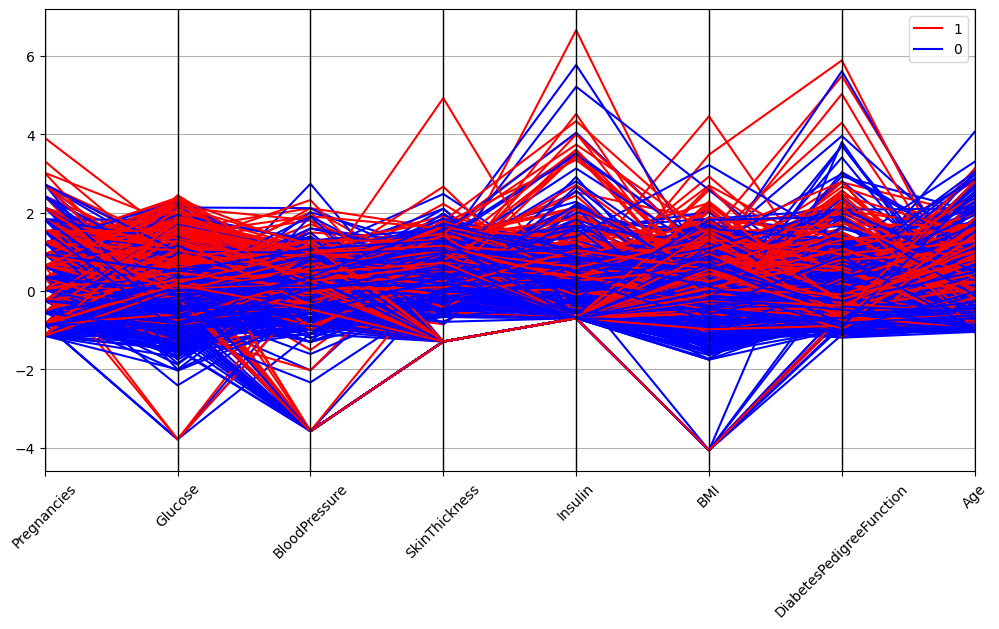

In [5]:
# Escalar las características del DataFrame, excluyendo la columna 'Outcome'
df_sc = pd.DataFrame(StandardScaler().fit_transform(df.drop(['Outcome'], axis=1)), columns=df.columns[:-1])
df_sc['Outcome'] = df.Outcome

# Creamos un gráfico de coordenadas paralelas para visualizar las características escaladas
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df_sc, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()

# Datos de Entrenamiento y de Prueba

In [6]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [7]:
# Leemos los datos entrenados y visualizamos 
train_data = pd.read_csv("../data/processed/clean_train.csv")
test_data = pd.read_csv("../data/processed/clean_test.csv")

train_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,y
0,2,84,0,0,0,0.0,0.304,21,0
1,9,112,82,24,0,28.2,1.282,50,1
2,1,139,46,19,83,28.7,0.654,22,0
3,0,161,50,0,0,21.9,0.254,65,0
4,6,134,80,37,370,46.2,0.238,46,1


In [8]:
# Separamos nuestros datos de entrenamiento y prueba
X_train = train_data.drop(["y"], axis = 1)
y_train = train_data["y"]
X_test = test_data.drop(["y"], axis = 1)
y_test = test_data["y"]

# Modelo de Random Forest

In [9]:
# Definimos la clase RF
class RandomForestCustom:

  def __init__(self, n_estimators, random_state, max_depth, min_samples_leaf, max_features, X, y):
    self.n_estimators = n_estimators
    self.random_state = random_state
    self.max_depth = max_depth
    self.min_samples_leaf = min_samples_leaf
    self.max_features = max_features
    self.X = X
    self.y = y
    self.models = []

  def get_bootstrap_datasets(self):
    seed(self.random_state)
    # Seleccionar aleatoriamente las filas que vamos a usar para entrenar cada árbol
    idxs = [choice(len(self.X), len(self.X), replace=True) for _ in range(self.n_estimators)]
    # Seleccionar aleatoriamente las columnas que vamos a usar para entrenar cada árbol
    feature_idxs = [choice(range(self.X.shape[1]), self.max_features, replace=False) for _ in range(self.n_estimators)]
    return feature_idxs, [(self.X[idxs[i],:][:,feature_idxs[i]], self.y[idxs[i]]) for i in range(self.n_estimators)]

  def fit(self):
    feature_idxs, data_sets = self.get_bootstrap_datasets()
    for i, data in enumerate(data_sets):
      X_i, y_i = data
      tree_i = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, max_features=self.max_features, random_state=self.random_state).fit(X_i, y_i)
      self.models.append((feature_idxs[i], tree_i))

  def predict(self, X):
    predictions = np.vstack([model.predict(X[:,idxs]) for idxs, model in self.models])
    predicciones = [Counter(predictions[:,i]).most_common(1)[0][0] for i in range(predictions.shape[1])]
    return predicciones

In [10]:
# Instanciamos la clase RF creando un modelo simple

rf_simple = RandomForestCustom(
    n_estimators=5,
    random_state=42,
    max_depth=2,
    min_samples_leaf=20,
    max_features=X_train.shape[1]//2,
    X=X_train.values,
    y=y_train.values)

rf_simple.fit()

In [11]:
# Instanciamos la clase RF creando un modelo complejo

rf_complex = RandomForestCustom(
    n_estimators=100,
    random_state=42,
    max_depth=20,
    min_samples_leaf=1,
    max_features=int(X_train.shape[1]*0.8),
    X=X_train.values,
    y=y_train.values)

rf_complex.fit()

In [12]:
# Evaluar el modelo simple en entrenamiento y prueba
train_pred_simple = rf_simple.predict(X_train.values)
test_pred_simple = rf_simple.predict(X_test.values)

In [13]:
# Evaluar el modelo complejo en entrenamiento y prueba
train_pred_complex = rf_complex.predict(X_train.values)
test_pred_complex = rf_complex.predict(X_test.values)

# Métricas de Evaluación

In [14]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [15]:
# Métricas del modelo simple
get_metrics(y_train, y_test, train_pred_simple, test_pred_simple)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.771987,0.565217,0.691171,0.834862,0.427230,0.955112
Test,0.766234,0.590909,0.701010,0.787879,0.472727,0.929293
Diferencia,0.005753,-0.025692,-0.009839,0.046984,-0.045497,0.025819


In [16]:
# Métricas del modelo complejo
get_metrics(y_train, y_test, train_pred_complex, test_pred_complex)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Test,0.766234,0.689655,0.757576,0.655738,0.727273,0.787879
Diferencia,0.233766,0.310345,0.242424,0.344262,0.272727,0.212121


# Hiperparámetros

In [17]:
# Inicializamos un modelo base de Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [18]:
# Definimos el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]}  # Añadimos esta opción para más flexibilidad

In [19]:
# Definimos múltiples métricas para la evaluación
scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score, average='weighted'),
    'auc': make_scorer(roc_auc_score, average='weighted', multi_class='ovr'),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted')}

In [20]:
# Configuramos y ejecutamos GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='f1',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
    )
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estim

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'auc': make_scorer(roc_auc_score, response_method='predict', average=weighted, multi_class=ovr),
                      'f1': make_scorer(f1_score, response_method='predict', average=weighted),
                      'precision': make_scorer(precision_score, response_method='predict', average=weighted),
                      'recall': make_scorer(recall_score, response_method='predict', average=weighted)},
             verbose=2)

# Nuevo Modelo de Random Forest

In [21]:
# Definimos el modelo con los parámetros óptimos
RF = grid_search.best_estimator_

In [22]:
# Realizar predicciones en el conjunto de prueba
y_pred = RF.predict(X_test)

In [23]:
# Evaluar el modelo en entrenamiento y prueba
train_pred_RF = RF.predict(X_train)
test_pred_RF = RF.predict(X_test)

In [24]:
# Métricas del modelo optimizado
get_metrics(y_train, y_test, train_pred_RF, test_pred_RF)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.942997,0.915254,0.929946,0.945000,0.887324,0.972569
Test,0.753247,0.666667,0.739394,0.644068,0.690909,0.787879
Diferencia,0.189750,0.248588,0.190552,0.300932,0.196415,0.184690


In [25]:
# Evaluación en test
y_pred = RF.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy en el conjunto de prueba: {accuracy:.4f}")

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Accuracy en el conjunto de prueba: 0.7532

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80        99
           1       0.64      0.69      0.67        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.74       154
weighted avg       0.76      0.75      0.76       154



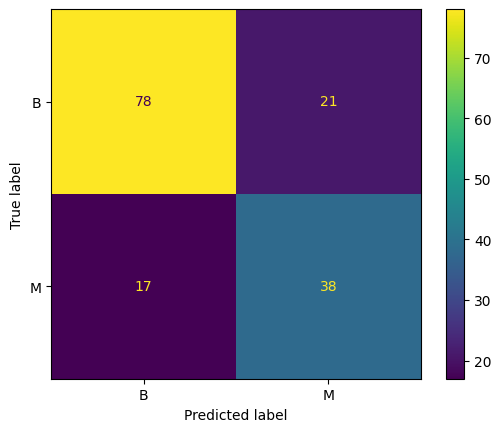

In [26]:
# Gráfico de la matriz de confusión
cm = confusion_matrix(y_test, test_pred_RF)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['B', 'M'])
disp.plot()

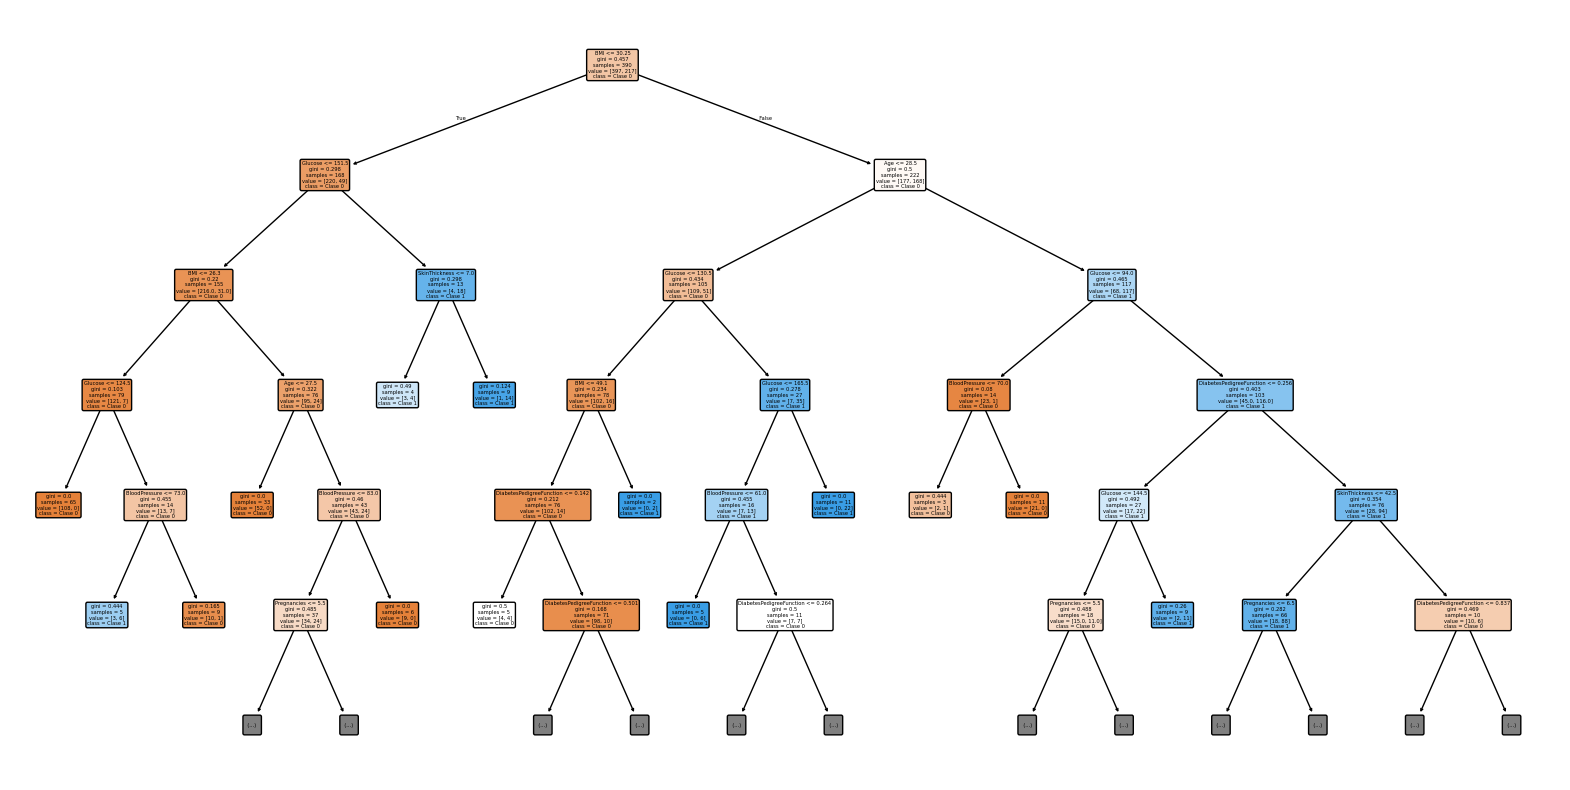

In [27]:
# Diagrama de árbol
# Selecciona un árbol dentro del bosque (el primero)
tree_index = 0
single_tree = RF.estimators_[tree_index]  # Extrae un árbol

# Graficar el árbol
plt.figure(figsize=(20, 10))
plot_tree(
    single_tree,
    feature_names=X_train.columns,  # Nombres de las características
    class_names=['Clase 0', 'Clase 1'],  # Nombres de las clases
    filled=True,
    rounded=True,
    max_depth=5  # Limitar la profundidad para visualización
)
plt.show()

# Save los archivos

In [28]:
# Guardamos el modelo
from pickle import dump

dump(rf_simple, open("../models/RandomForestSimple.sav", "wb"))
dump(rf_complex, open("../models/RandomForestComplejo.sav", "wb"))
dump(RF, open("../models/RandomForestOptimizado.sav", "wb"))

# Conclusiones

El modelo optimizado es el más versátil, pero requiere ajustes adicionales para reducir su overfitting. El modelo simple es una opción conservadora válida en entornos donde la estabilidad es prioritaria.

Análisis Comparativo:

Accuracy:  Todos tienen accuracy similar. No es la métrica más informativa en desbalance

F1-Score:  Modelo complejo lidera, pero con sobreajuste. Optimizado logra equilibrio.

AUC:          Modelo complejo tiene mejor capacidad discriminativa, pero optimizado es más estable

Precisión:    Modelo simple es mejor para minimizar falsos positivos.

Recall:	      Modelo complejo capta más positivos, pero a costa de precisión.

Especificidad: Modelo simple es superior para identificar negativos correctamente.